In [1]:
## import os
import sys
import numpy as np
import networkx as nx
import itertools as it
import random as rd
import pickle as pk
import os.path
import pandas as pd
from collections import (defaultdict,Counter)
import time
import matplotlib.pyplot as plt
# %matplotlib inline

chem_vocabolary = pd.read_csv("input/CTD/CTD_chemicals_cleaned.txt",delimiter= '\t',
           skipinitialspace=True)

chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t',
            skipinitialspace=True)

chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]

chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])

#Here, we remove the elements that do not perturb any genes:
chem_gene_cleaned = {}
tot_gene_list=[]
for k,v in chem_gene.items():
    if len(v)>0:
        chem_gene_cleaned[k]=v
        for gene in v:
            tot_gene_list.append(gene)
    else:
        pass


chem_voc_dict = {}
for i,v in chem_vocabolary.iterrows():
    try:
        chem_voc_dict[v["ChemicalID"]] = v["ParentIDs"].split("|")
    except:
        chem_voc_dict[v["ChemicalID"]] = v["ParentIDs"]

from collections.abc import Mapping
# Empty directed graph
G = nx.DiGraph()

for k in chem_voc_dict.keys():
    try:
        for v in chem_voc_dict[k]:
            G.add_edge(k, v)
    except:
        G.add_edge(k,"D")

classes_list=[]
for i in G.nodes():
    if len(nx.predecessor(G, i))==2:
        classes_list.append(i)

#Let's clean the list from the nan elements
classes_list_cleaned = [x for x in classes_list if str(x) != 'nan']

#Let's associate a specific color for each chemical group
colors=['#D52EBF','#FFA1FF','#49CDAB','#AB9DF6','#7F41FF','#B74C6B','#00D99D','#43C9C2','#00F9FA','#DD66BD','#437FC2','#4BCDFF'] 
class_color_dict={}
for i in range(len(classes_list_cleaned)):
    class_color_dict[classes_list_cleaned[i]]=colors[i]
    
ppi = pd.read_csv("input/PPI/autocore_symbol_lcc.csv",delimiter= ',',
           skipinitialspace=True)

G_ppi = nx.from_pandas_edgelist(ppi, 'symbol1', 'symbol2')

G_ppi_lcc = G_ppi.subgraph(max(nx.connected_components(G_ppi), key=len))  # extract lcc graph
print(G_ppi_lcc.number_of_nodes())
print(G_ppi_lcc.number_of_edges())

chem_gene_dictio_cleaned_ppi={}
for k,v in chem_gene_cleaned.items():
    new_list=[]
    for gene in v:
        if gene in G_ppi_lcc.nodes():
            new_list.append(gene)
        else:
            pass
    if len(new_list)>0:
        chem_gene_dictio_cleaned_ppi[k]=new_list
    else:
        pass




18815
482935


In [2]:
#Let's import the EEN
filtered_weighted_exp_graph_significant = nx.read_weighted_edgelist("output/backbone_exp_graph_significant_weighted.edgelist")


In [2]:
with open('output/chem_gene_hq.pickle', 'rb') as handle:
    chem_gene_hq = pk.load(handle)
with open('output/chem_gene_homo_mouse.pickle', 'rb') as handle:
    chem_gene_homo_mouse = pk.load(handle)


In [ ]:
import math
exposome_zscore={}

for exp in chem_gene_dictio_cleaned_ppi.keys():
    geneset = set(chem_gene_dictio_cleaned_ppi[exp])

    G_sub = nx.subgraph(G_ppi_lcc,geneset)

    G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph


    f_lcc_size = G_sub_lcc.number_of_nodes()
    l_random_lccs = []

    S = 1000
    for s in range(S):
        gene_sample = rd.sample(G_ppi_lcc.nodes(),len(geneset))
        G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)

        G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
        lcc_size = G_sub_rnd_lcc.number_of_nodes()
        l_random_lccs.append(lcc_size)
    mu = np.mean(l_random_lccs)
    std = np.std(l_random_lccs)

    z = round(((f_lcc_size-mu)/std),3)


    exposome_zscore[exp]=z

with open('intermediate/exposome_zscore.pickle', 'wb') as handle:
    pk.dump(exposome_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)

In [2]:
#We are importing here the dictionary that correspnds for each chemical a 
#z-score based on their connectivity (if exposure tends to perturb a well
#localized neighborhood they will have a higher z-score)
import pickle as pk
with open('intermediate/exposome_zscore.pickle', 'rb') as handle:
    exposome_zscore = pk.load(handle)

In [9]:
add_exp_zscore={}
for exp,z in exposome_zscore.items():
    if str(z)=="nan" or str(z)=="inf":
        if len(chem_gene_dictio_cleaned_ppi[exp])>1:
            geneset = set(chem_gene_dictio_cleaned_ppi[exp])

            G_sub = nx.subgraph(G_ppi_lcc,geneset)
            G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph
            
            f_lcc_size = G_sub_lcc.number_of_nodes()
            l_random_lccs = []

            S = 1000
            for s in range(S):
                gene_sample = rd.sample(G_ppi_lcc.nodes(),len(geneset))
                G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)

                G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
                lcc_size = G_sub_rnd_lcc.number_of_nodes()
                l_random_lccs.append(lcc_size)
            mu = np.mean(l_random_lccs)
            std = np.std(l_random_lccs)

            z = round(((f_lcc_size-mu)/std),3)
            add_exp_zscore[exp]=z


<ipython-input-9-e3802fb73463>:24: RuntimeWarning: invalid value encountered in double_scalars
  z = round(((f_lcc_size-mu)/std),3)


In [11]:
#Let's do it one more time (the last one)
add_add_exp_zscore={}
for exp,z in add_exp_zscore.items():
    if str(z)=="nan" or str(z)=="inf":
        if len(chem_gene_dictio_cleaned_ppi[exp])>1:
            geneset = set(chem_gene_dictio_cleaned_ppi[exp])

            G_sub = nx.subgraph(G_ppi_lcc,geneset)
            G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph
            
            f_lcc_size = G_sub_lcc.number_of_nodes()
            l_random_lccs = []

            S = 1000
            for s in range(S):
                gene_sample = rd.sample(G_ppi_lcc.nodes(),len(geneset))
                G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)

                G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
                lcc_size = G_sub_rnd_lcc.number_of_nodes()
                l_random_lccs.append(lcc_size)
            mu = np.mean(l_random_lccs)
            std = np.std(l_random_lccs)

            z = round(((f_lcc_size-mu)/std),3)
            add_add_exp_zscore[exp]=z


In [14]:
#Let's make a final z-score dict
final_exposome_zscore={}
for exp,z in exposome_zscore.items():
    if len(chem_gene_dictio_cleaned_ppi[exp])>1:   #I remove those exposures that perturb just one gene
        if str(z)!="nan" and str(z)!="inf":
            final_exposome_zscore[exp]=z
        else:
            if str(add_exp_zscore[exp])!="nan" and str(add_exp_zscore[exp])!="inf":
                final_exposome_zscore[exp]=add_exp_zscore[exp]
            else:
                final_exposome_zscore[exp]=add_add_exp_zscore[exp]

In [15]:
len(final_exposome_zscore)

7177

In [16]:
with open('intermediate/final_exposome_zscore.pickle', 'wb') as handle:
    pk.dump(final_exposome_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)

In [11]:
#Lets import it
with open('intermediate/final_exposome_zscore.pickle', 'rb') as handle:
    final_exposome_zscore = pk.load(handle)

In [ ]:
#Let's look at the lcc z-score distribution of the final_exposome_zscore 

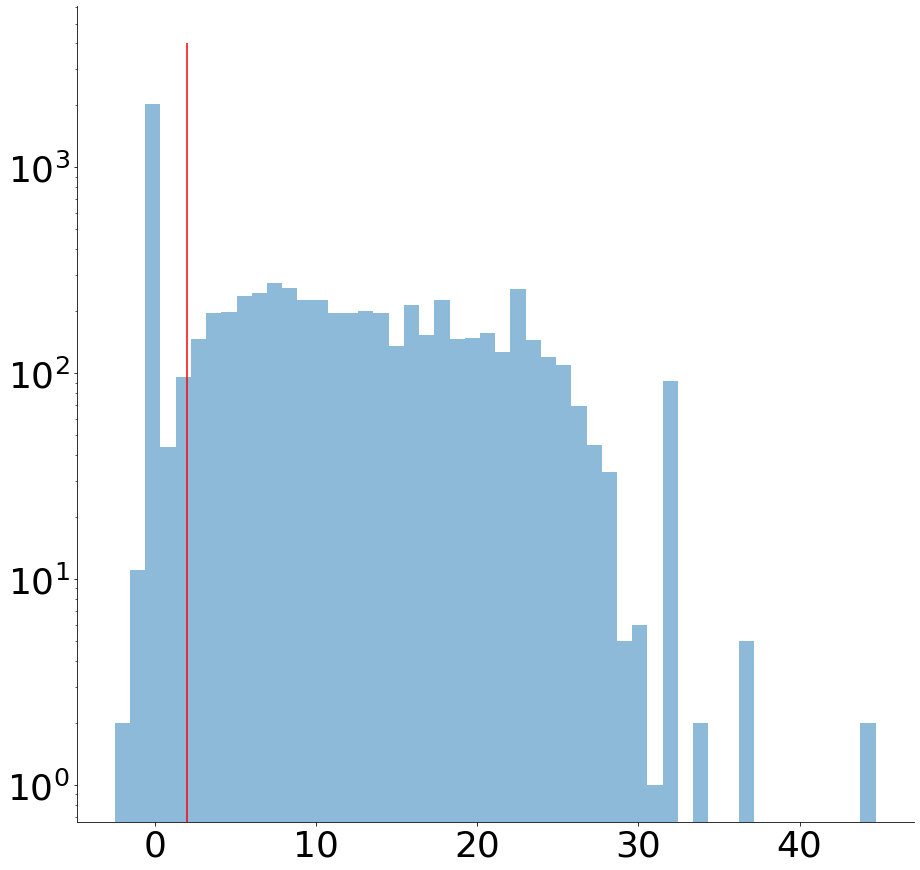

In [18]:
fig, ax = plt.subplots(figsize=(15,15))
plt.hist(list(final_exposome_zscore.values()), bins=50, alpha=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#plt.xlabel('z-score',fontsize=22)
#plt.ylabel('Frequency', fontsize=22)
plt.yscale('log')
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36)
plt.vlines(x=2,ymin=0,ymax=4000,color='r',label='statistically significance')



In [20]:
np.mean(list(final_exposome_zscore.values()))

9.717749616831544

In [21]:
np.median(list(final_exposome_zscore.values()))

8.392

In [ ]:
#Let's compare now with the performance given by the communities

In [11]:
#Let's import the renamed Louvain communities


with open('output/Communities/Louvain/weighted_ji_fine_grained_communities_dict.pickle', 'rb') as handle:
    fine_grained_communities_dict = pk.load(handle)   
with open('output/Communities/Louvain/weighted_ji_middle_communities_dict.pickle', 'rb') as handle:
    middle_communities_dict = pk.load(handle)       
with open('output/Communities/Louvain/weighted_ji_broad_communities_dict.pickle', 'rb') as handle:
    broad_communities_dict = pk.load(handle)       
    

In [12]:
import math
import random as rd
fine_grained_communities_lcc_zscore={}
fine_grained_communities_genes_ppi={}
for com,exp_list in fine_grained_communities_dict.items():
    genelist=[]
    for exp in exp_list:
        try:
            genelist.extend(chem_gene_dictio_cleaned_ppi[exp])
        except:
            pass
    fine_grained_communities_genes_ppi[com]=set(genelist)
    
for com,geneset in fine_grained_communities_genes_ppi.items():
    try:
        G_sub = nx.subgraph(G_ppi_lcc,geneset)
        G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph


        f_lcc_size = G_sub_lcc.number_of_nodes()
        l_random_lccs = []

        S = 1000
        for s in range(S):
            gene_sample = rd.sample(list(G_ppi_lcc.nodes()),len(geneset))
            G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)

            G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
            lcc_size = G_sub_rnd_lcc.number_of_nodes()
            l_random_lccs.append(lcc_size)
        mu = np.mean(l_random_lccs)
        std = np.std(l_random_lccs)

        z = round(((f_lcc_size-mu)/std),3)
    except:
        z = 'nan'

    fine_grained_communities_lcc_zscore[com]=z

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_38161/2620050837.py:34: RuntimeWarning: invalid value encountered in scalar divide
  z = round(((f_lcc_size-mu)/std),3)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_38161/2620050837.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  z = round(((f_lcc_size-mu)/std),3)


In [41]:
len(fine_grained_communities_lcc_zscore)

456

In [8]:
for com,z in fine_grained_communities_lcc_zscore.items():
    if str(z)=='nan':
        geneset=fine_grained_communities_genes_ppi[com]
        if len(geneset)>3:
            try:
                G_sub = nx.subgraph(G_ppi_lcc,geneset)
                G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph
                f_lcc_size = G_sub_lcc.number_of_nodes()
                l_random_lccs = []

                S = 1000
                for s in range(S):
                    gene_sample = rd.sample(list(G_ppi_lcc.nodes()),len(geneset))
                    G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)

                    G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
                    lcc_size = G_sub_rnd_lcc.number_of_nodes()
                    l_random_lccs.append(lcc_size)
                mu = np.mean(l_random_lccs)
                std = np.std(l_random_lccs)

                z = round(((f_lcc_size-mu)/std),3)
            except:
                z = 'nan'
        fine_grained_communities_lcc_zscore[com]=z
    else:
        pass
    

In [9]:
import math
import random as rd
middle_communities_lcc_zscore={}
middle_communities_genes_ppi={}
for com,exp_list in middle_communities_dict.items():
    genelist=[]
    for exp in exp_list:
        try:
            genelist.extend(chem_gene_dictio_cleaned_ppi[exp])
        except:
            pass
    middle_communities_genes_ppi[com]=set(genelist)
    
for com,geneset in middle_communities_genes_ppi.items():
    try:
        G_sub = nx.subgraph(G_ppi_lcc,geneset)
        G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph


        f_lcc_size = G_sub_lcc.number_of_nodes()
        l_random_lccs = []

        S = 1000
        for s in range(S):
            gene_sample = rd.sample(list(G_ppi_lcc.nodes()),len(geneset))
            G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)

            G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
            lcc_size = G_sub_rnd_lcc.number_of_nodes()
            l_random_lccs.append(lcc_size)
        mu = np.mean(l_random_lccs)
        std = np.std(l_random_lccs)

        z = round(((f_lcc_size-mu)/std),3)
    except:
        z = 'nan'

    middle_communities_lcc_zscore[com]=z

In [10]:
for com,z in middle_communities_lcc_zscore.items():
    if str(z)=='nan':
        geneset=middle_communities_genes_ppi[com]
        if len(geneset)>3:
            try:
                G_sub = nx.subgraph(G_ppi_lcc,geneset)
                G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph
                f_lcc_size = G_sub_lcc.number_of_nodes()
                l_random_lccs = []

                S = 1000
                for s in range(S):
                    gene_sample = rd.sample(list(G_ppi_lcc.nodes()),len(geneset))
                    G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)

                    G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
                    lcc_size = G_sub_rnd_lcc.number_of_nodes()
                    l_random_lccs.append(lcc_size)
                mu = np.mean(l_random_lccs)
                std = np.std(l_random_lccs)

                z = round(((f_lcc_size-mu)/std),3)
            except:
                z = 'nan'
        middle_communities_lcc_zscore[com]=z
    else:
        pass

In [11]:
import math
import random as rd
broad_communities_lcc_zscore={}
broad_communities_genes_ppi={}
for com,exp_list in broad_communities_dict.items():
    genelist=[]
    for exp in exp_list:
        try:
            genelist.extend(chem_gene_dictio_cleaned_ppi[exp])
        except:
            pass
    broad_communities_genes_ppi[com]=set(genelist)
    
for com,geneset in broad_communities_genes_ppi.items():
    try:
        G_sub = nx.subgraph(G_ppi_lcc,geneset)
        G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph


        f_lcc_size = G_sub_lcc.number_of_nodes()
        l_random_lccs = []

        S = 1000
        for s in range(S):
            gene_sample = rd.sample(list(G_ppi_lcc.nodes()),len(geneset))
            G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)

            G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
            lcc_size = G_sub_rnd_lcc.number_of_nodes()
            l_random_lccs.append(lcc_size)
        mu = np.mean(l_random_lccs)
        std = np.std(l_random_lccs)

        z = round(((f_lcc_size-mu)/std),3)
    except:
        z = 'nan'

    broad_communities_lcc_zscore[com]=z

In [12]:
for com,z in broad_communities_lcc_zscore.items():
    if str(z)=='nan':
        geneset=broad_communities_genes_ppi[com]
        if len(geneset)>3:
            try:
                G_sub = nx.subgraph(G_ppi_lcc,geneset)
                G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph
                f_lcc_size = G_sub_lcc.number_of_nodes()
                l_random_lccs = []

                S = 1000
                for s in range(S):
                    gene_sample = rd.sample(list(G_ppi_lcc.nodes()),len(geneset))
                    G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)

                    G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
                    lcc_size = G_sub_rnd_lcc.number_of_nodes()
                    l_random_lccs.append(lcc_size)
                mu = np.mean(l_random_lccs)
                std = np.std(l_random_lccs)

                z = round(((f_lcc_size-mu)/std),3)
            except:
                z = 'nan'
        broad_communities_lcc_zscore[com]=z
    else:
        pass

In [24]:
lcc_zscore_df=pd.DataFrame()

category_list=[]
zscore_list=[]
for z in [v for v in final_exposome_zscore.values() if str(v)!='nan' and str(v)!='inf']:
    zscore_list.append(z)
    category_list.append("all exposures")
 
for z in [v for v in fine_grained_communities_lcc_zscore.values() if str(v)!='nan' and str(v)!='inf']:
    zscore_list.append(z)
    category_list.append("fine-grained")

for z in [v for v in middle_communities_lcc_zscore.values() if str(v)!='nan' and str(v)!='inf']:
    zscore_list.append(z)
    category_list.append("intermediate")   
    
for z in [v for v in broad_communities_lcc_zscore.values() if str(v)!='nan' and str(v)!='inf']:
    zscore_list.append(z)
    category_list.append("broad")    

lcc_zscore_df['group']=category_list
lcc_zscore_df['z-score']=zscore_list

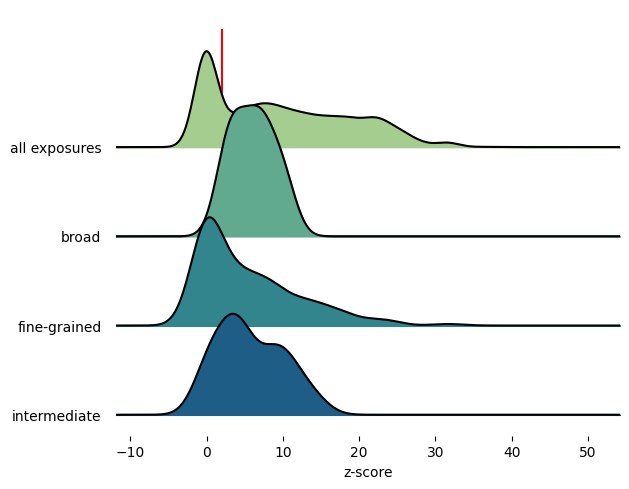

In [30]:
from joypy import joyplot
import seaborn as sns

joyplot(lcc_zscore_df, by='group', column='z-score',colormap=sns.color_palette("crest", as_cmap=True));

plt.xlabel('z-score');
plt.vlines(x=2,ymin=0,ymax=1,color='r',label='statistically significance',zorder=10);
plt.savefig('output/Figures/Fig3D_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

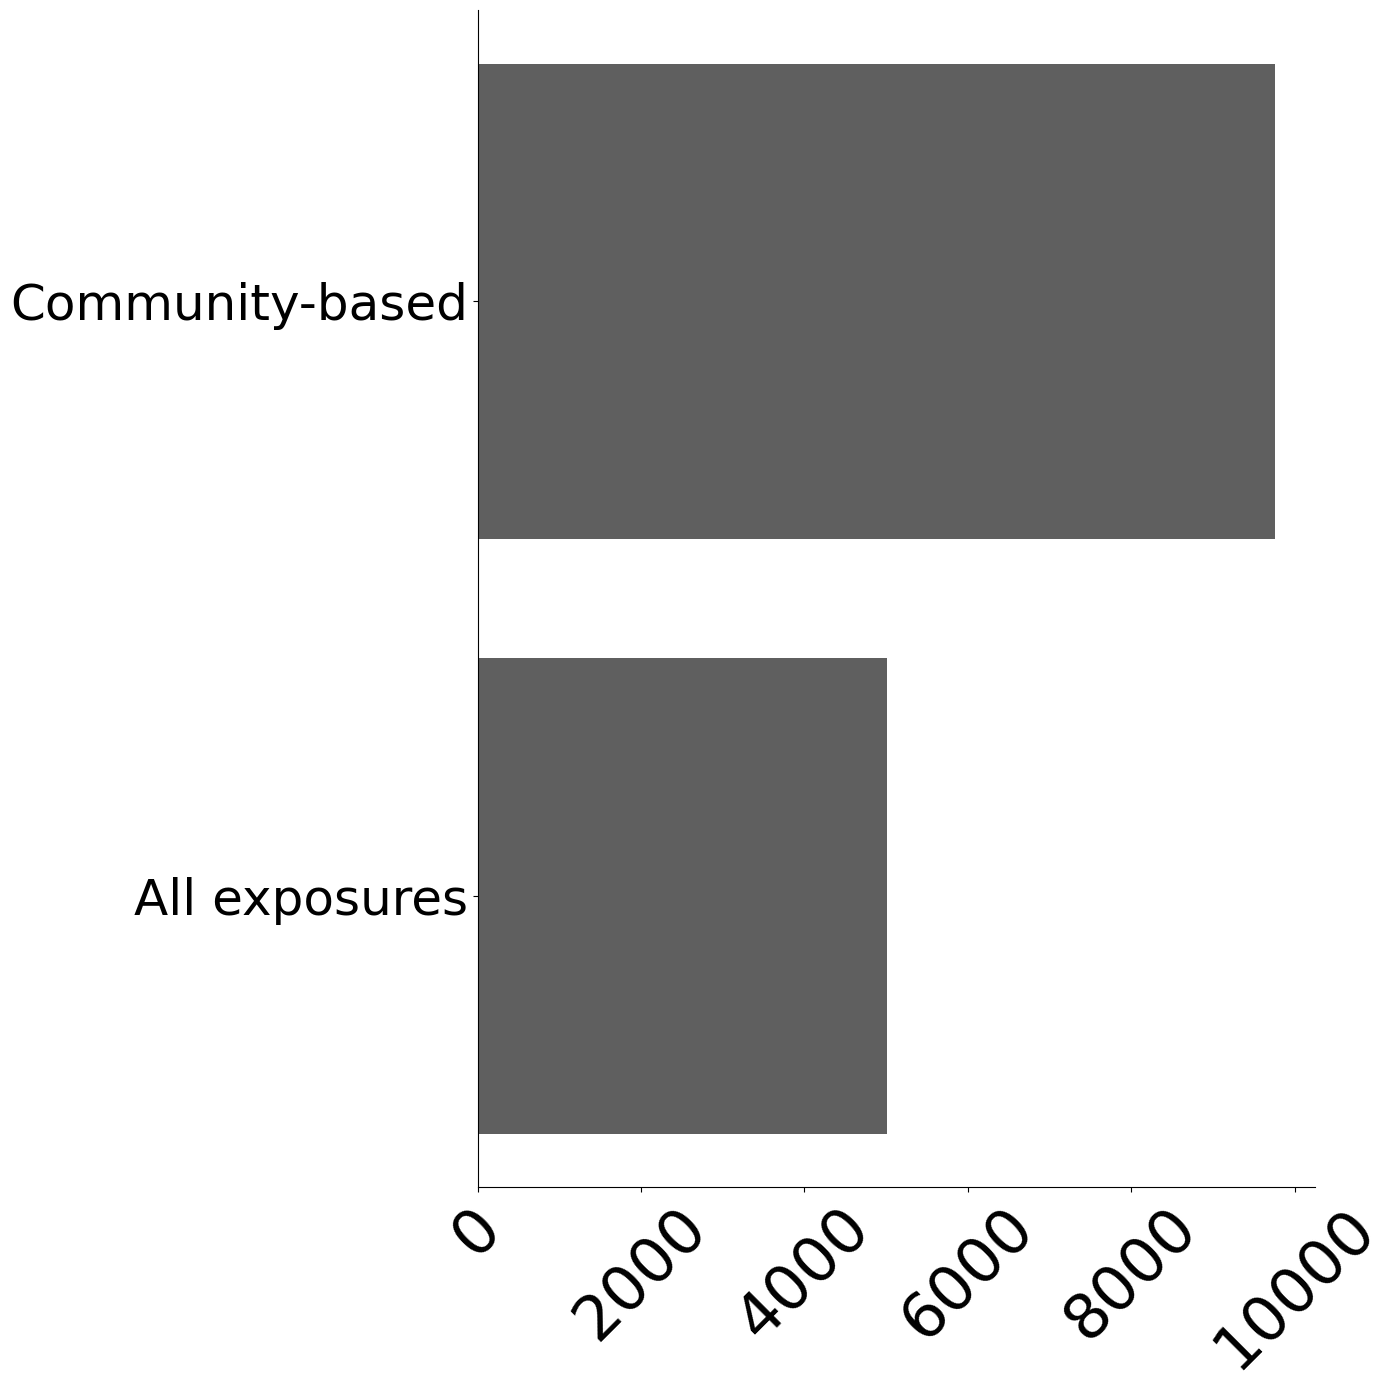

In [35]:
#Let's do it again, but this time we plot the number of exposures that are associated with a statistically significant
#neighborhood and not those that we lose


from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
fig1, ax1 = plt.subplots(figsize=(14, 14))

x = np.arange(2)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

not_module_exposure_list=[]
tot_backboneexposures=filtered_weighted_exp_graph_significant.number_of_nodes()

for exp in filtered_weighted_exp_graph_significant.nodes():
    try:
        if float(final_exposome_zscore[exp])<2:
            not_module_exposure_list.append(exp)
        else:
            pass
    except:
        not_module_exposure_list.append(exp)

not_module_exposure_com_list=[]
for exp in filtered_weighted_exp_graph_significant.nodes():
    for com,explist in fine_grained_communities_dict.items():
        if exp in explist:
            if float(fine_grained_communities_lcc_zscore[com])<2:
                for com2,explist2 in middle_communities_dict.items():
                    if exp in explist2:
                        if float(middle_communities_lcc_zscore[com2])<2:
                            for com3,explist3 in broad_communities_dict.items():
                                if exp in explist3:
                                    if float(broad_communities_lcc_zscore[com3])<2:
                                        not_module_exposure_com_list.append(exp)
                

module_exposure_list_tot=[tot_backboneexposures-len(not_module_exposure_list),tot_backboneexposures-len(not_module_exposure_com_list)]
label=['All exposures', 'Community-based']

    
plt.barh(x, module_exposure_list_tot,color='#5F5F5F')
#plt.title('Frequency of exposures rank by their degree',fontsize=32)
#plt.ylabel('Frequency',fontsize=20)
#plt.xlabel('Number of exposures',fontsize=45)
plt.xticks(fontsize=45,rotation=45)
plt.yticks(x, label,fontsize=36,ha='right')
#plt.yticks([],fontsize=45,rotation=45,ha='right')
plt.tight_layout()

plt.savefig('output/Figures/Fig3E_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()



### Infomap

In [3]:
#Let's import the infomap communities

with open('output/Communities/Infomap/ji_infomap_fine_grained_communities_dict.pickle', 'rb') as handle:
    fine_grained_communities_dict = pk.load(handle)
with open('output/Communities/Infomap/ji_infomap_middle_communities_dict.pickle', 'rb') as handle:
    middle_communities_dict = pk.load(handle)
with open('output/Communities/Infomap/ji_infomap_broad_communities_dict.pickle', 'rb') as handle:
    broad_communities_dict = pk.load(handle)
    

In [4]:
import math
import random as rd
fine_grained_communities_lcc_zscore={}
fine_grained_communities_genes_ppi={}
for com,exp_list in fine_grained_communities_dict.items():
    genelist=[]
    for exp in exp_list:
        try:
            genelist.extend(chem_gene_dictio_cleaned_ppi[exp])
        except:
            pass
    fine_grained_communities_genes_ppi[com]=set(genelist)
    
for com,geneset in fine_grained_communities_genes_ppi.items():
    try:
        G_sub = nx.subgraph(G_ppi_lcc,geneset)
        G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph


        f_lcc_size = G_sub_lcc.number_of_nodes()
        l_random_lccs = []

        S = 1000
        for s in range(S):
            gene_sample = rd.sample(list(G_ppi_lcc.nodes()),len(geneset))
            G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)

            G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
            lcc_size = G_sub_rnd_lcc.number_of_nodes()
            l_random_lccs.append(lcc_size)
        mu = np.mean(l_random_lccs)
        std = np.std(l_random_lccs)

        z = round(((f_lcc_size-mu)/std),3)
    except:
        z = 'nan'

    fine_grained_communities_lcc_zscore[com]=z

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_34140/2620050837.py:34: RuntimeWarning: invalid value encountered in scalar divide
  z = round(((f_lcc_size-mu)/std),3)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_34140/2620050837.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  z = round(((f_lcc_size-mu)/std),3)


In [5]:
for com,z in fine_grained_communities_lcc_zscore.items():
    if str(z)=='nan':
        geneset=fine_grained_communities_genes_ppi[com]
        if len(geneset)>3:
            try:
                G_sub = nx.subgraph(G_ppi_lcc,geneset)
                G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph
                f_lcc_size = G_sub_lcc.number_of_nodes()
                l_random_lccs = []

                S = 1000
                for s in range(S):
                    gene_sample = rd.sample(list(G_ppi_lcc.nodes()),len(geneset))
                    G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)

                    G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
                    lcc_size = G_sub_rnd_lcc.number_of_nodes()
                    l_random_lccs.append(lcc_size)
                mu = np.mean(l_random_lccs)
                std = np.std(l_random_lccs)

                z = round(((f_lcc_size-mu)/std),3)
            except:
                z = 'nan'
        fine_grained_communities_lcc_zscore[com]=z
    else:
        pass
    

In [6]:
import math
import random as rd
middle_communities_lcc_zscore={}
middle_communities_genes_ppi={}
for com,exp_list in middle_communities_dict.items():
    genelist=[]
    for exp in exp_list:
        try:
            genelist.extend(chem_gene_dictio_cleaned_ppi[exp])
        except:
            pass
    middle_communities_genes_ppi[com]=set(genelist)
    
for com,geneset in middle_communities_genes_ppi.items():
    try:
        G_sub = nx.subgraph(G_ppi_lcc,geneset)
        G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph


        f_lcc_size = G_sub_lcc.number_of_nodes()
        l_random_lccs = []

        S = 1000
        for s in range(S):
            gene_sample = rd.sample(list(G_ppi_lcc.nodes()),len(geneset))
            G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)

            G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
            lcc_size = G_sub_rnd_lcc.number_of_nodes()
            l_random_lccs.append(lcc_size)
        mu = np.mean(l_random_lccs)
        std = np.std(l_random_lccs)

        z = round(((f_lcc_size-mu)/std),3)
    except:
        z = 'nan'

    middle_communities_lcc_zscore[com]=z

In [7]:
for com,z in middle_communities_lcc_zscore.items():
    if str(z)=='nan':
        geneset=middle_communities_genes_ppi[com]
        if len(geneset)>3:
            try:
                G_sub = nx.subgraph(G_ppi_lcc,geneset)
                G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph
                f_lcc_size = G_sub_lcc.number_of_nodes()
                l_random_lccs = []

                S = 1000
                for s in range(S):
                    gene_sample = rd.sample(list(G_ppi_lcc.nodes()),len(geneset))
                    G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)

                    G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
                    lcc_size = G_sub_rnd_lcc.number_of_nodes()
                    l_random_lccs.append(lcc_size)
                mu = np.mean(l_random_lccs)
                std = np.std(l_random_lccs)

                z = round(((f_lcc_size-mu)/std),3)
            except:
                z = 'nan'
        middle_communities_lcc_zscore[com]=z
    else:
        pass

In [8]:
import math
import random as rd
broad_communities_lcc_zscore={}
broad_communities_genes_ppi={}
for com,exp_list in broad_communities_dict.items():
    genelist=[]
    for exp in exp_list:
        try:
            genelist.extend(chem_gene_dictio_cleaned_ppi[exp])
        except:
            pass
    broad_communities_genes_ppi[com]=set(genelist)
    
for com,geneset in broad_communities_genes_ppi.items():
    try:
        G_sub = nx.subgraph(G_ppi_lcc,geneset)
        G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph


        f_lcc_size = G_sub_lcc.number_of_nodes()
        l_random_lccs = []

        S = 1000
        for s in range(S):
            gene_sample = rd.sample(list(G_ppi_lcc.nodes()),len(geneset))
            G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)

            G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
            lcc_size = G_sub_rnd_lcc.number_of_nodes()
            l_random_lccs.append(lcc_size)
        mu = np.mean(l_random_lccs)
        std = np.std(l_random_lccs)

        z = round(((f_lcc_size-mu)/std),3)
    except:
        z = 'nan'

    broad_communities_lcc_zscore[com]=z

In [9]:
for com,z in broad_communities_lcc_zscore.items():
    if str(z)=='nan':
        geneset=broad_communities_genes_ppi[com]
        if len(geneset)>3:
            try:
                G_sub = nx.subgraph(G_ppi_lcc,geneset)
                G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph
                f_lcc_size = G_sub_lcc.number_of_nodes()
                l_random_lccs = []

                S = 1000
                for s in range(S):
                    gene_sample = rd.sample(list(G_ppi_lcc.nodes()),len(geneset))
                    G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)

                    G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
                    lcc_size = G_sub_rnd_lcc.number_of_nodes()
                    l_random_lccs.append(lcc_size)
                mu = np.mean(l_random_lccs)
                std = np.std(l_random_lccs)

                z = round(((f_lcc_size-mu)/std),3)
            except:
                z = 'nan'
        broad_communities_lcc_zscore[com]=z
    else:
        pass

In [12]:
lcc_zscore_df=pd.DataFrame()

category_list=[]
zscore_list=[]
for z in [v for v in final_exposome_zscore.values() if str(v)!='nan' and str(v)!='inf']:
    zscore_list.append(z)
    category_list.append("all exposures")
 
for z in [v for v in fine_grained_communities_lcc_zscore.values() if str(v)!='nan' and str(v)!='inf']:
    zscore_list.append(z)
    category_list.append("fine-grained")

for z in [v for v in middle_communities_lcc_zscore.values() if str(v)!='nan' and str(v)!='inf']:
    zscore_list.append(z)
    category_list.append("intermediate")   
    
for z in [v for v in broad_communities_lcc_zscore.values() if str(v)!='nan' and str(v)!='inf']:
    zscore_list.append(z)
    category_list.append("broad")    

lcc_zscore_df['group']=category_list
lcc_zscore_df['z-score']=zscore_list

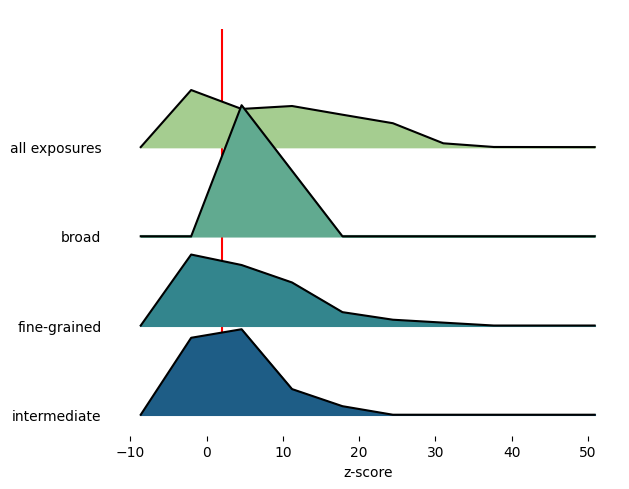

In [13]:
from joypy import joyplot
import seaborn as sns

joyplot(lcc_zscore_df, by='group', kind = "normalized_counts",column='z-score',colormap=sns.color_palette("crest", as_cmap=True));

plt.xlabel('z-score');
plt.vlines(x=2,ymin=0,ymax=1,color='r',label='statistically significance',zorder=10);
plt.savefig('output/Figures/SF16E_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [47]:
#Here we define the 90* percentile of the degree distribution
degree_list=[]
for i in G_ppi_lcc.nodes():
    degree_list.append(G_ppi_lcc.degree[i])
a = np.array(degree_list)
degree_90percentile = np.percentile(a, 90)

In [5]:
#Let's check if an exposure form a module, if it doesn't then we will check if it targets an hub gene
hub_exposures={}
exp_significant_modules={}
for k,v in exposome_zscore.items():
    if float(v)>2:
        exp_significant_modules[k]=v
    else:
        geneset=chem_gene_dictio_cleaned_ppi[k]
        geneset_degree=[]
        for gene in geneset:
            geneset_degree.append(G_ppi_lcc.degree[gene])
            if any(y > degree_90percentile for y in geneset_degree):
                    hub_exposures[k]=v
            else:
                pass

In [24]:

exp_significant_modules_central={}
exp_significant_modules_peripheric={}
for k,v in exp_significant_modules.items():
    geneset=chem_gene_dictio_cleaned_ppi[k]
    geneset_degree=[]
    for gene in geneset:
        geneset_degree.append(G_ppi_lcc.degree[gene])
    if any(y > degree_90percentile for y in geneset_degree):
        exp_significant_modules_central[k]=v
    else:
        exp_significant_modules_peripheric[k]=v


In [25]:
hub_exp_ss_module=set(list(exp_significant_modules.keys())+list(hub_exposures.keys()))

In [26]:
no_central_no_module=[]
for k,v in exposome_zscore.items():
    if k not in hub_exp_ss_module:
        no_central_no_module.append(k)

In [27]:
len(set(no_central_no_module))

3370

In [28]:
output_file = open('output/No_central_no_module_exposures.txt', 'w')

for exp in no_central_no_module:
    output_file.write(exp + '\n')

output_file.close()

In [29]:
output_file = open('output/Hub_expusres.txt', 'w')

for exp in list(hub_exposures.keys()):
    output_file.write(exp + '\n')

output_file.close()

In [30]:
output_file = open('output/Central_module_exposures.txt', 'w')

for exp in list(exp_significant_modules_central.keys()):
    output_file.write(exp + '\n')

output_file.close()

In [31]:
output_file = open('output/Peripheric_module_exposures.txt', 'w')

for exp in list(exp_significant_modules_peripheric.keys()):
    output_file.write(exp + '\n')

output_file.close()

In [42]:
peripheric_module_exp_zscore=[]
peripheric_module_exp=[]
for k,v in classes_zscore_peripheric_module.items():
    peripheric_module_exp.extend(v)
peripheric_module_exp_unique=set(peripheric_module_exp)
for exp in peripheric_module_exp_unique:
    peripheric_module_exp_zscore.append(exp_significant_modules[exp])

In [43]:
central_module_exp_zscore=[]
central_module_exp=[]
for k,v in classes_zscore_central_module.items():
    central_module_exp.extend(v)
central_module_exp_unique=set(central_module_exp)
for exp in central_module_exp_unique:
    central_module_exp_zscore.append(exp_significant_modules[exp])

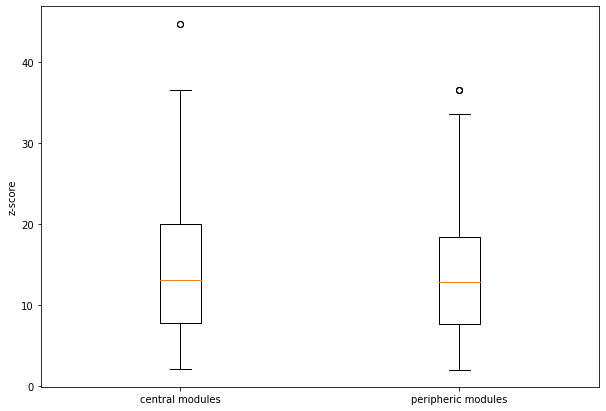

AttributeError: 'NoneType' object has no attribute 'lower'

In [44]:
import scipy
module_exp=[central_module_exp_zscore,peripheric_module_exp_zscore]
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_subplot(111)
 
# Creating plot
bp = ax.boxplot(module_exp)

ax.set_xticklabels(['central modules', 'peripheric modules'])
ax.set_ylabel('z-score')
# show plot
plt.show()
print(scipy.stats.mannwhitneyu(central_module_exp_zscore, peripheric_module_exp_zscore, use_continuity=True, alternative='two-sided'))


In [4]:
#Let's repeat for the perturbation case

#chem_gene_hq


chem_gene_hq_ppi={}
for k,v in chem_gene_hq.items():
    new_list=[]
    for gene in v:
        if gene in G_ppi_lcc.nodes():
            new_list.append(gene)
        else:
            pass
    if len(new_list)>0:
        chem_gene_hq_ppi[k]=new_list
    else:
        pass


import math
chem_gene_hq_ppi_zscore={}

for exp in chem_gene_hq_ppi.keys():
    geneset = set(chem_gene_hq_ppi[exp])
    G_sub = nx.subgraph(G_ppi_lcc,geneset)
    G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph

    f_lcc_size = G_sub_lcc.number_of_nodes()
    l_random_lccs = []

    S = 1000
    for s in range(S):
        gene_sample = rd.sample(list(G_ppi_lcc.nodes()),len(geneset))
        G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)
        G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
        lcc_size = G_sub_rnd_lcc.number_of_nodes()
        l_random_lccs.append(lcc_size)
    mu = np.mean(l_random_lccs)
    std = np.std(l_random_lccs)

    z = round(((f_lcc_size-mu)/std),3)

    chem_gene_hq_ppi_zscore[exp]=z


/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_38161/2071291305.py:41: RuntimeWarning: invalid value encountered in scalar divide
  z = round(((f_lcc_size-mu)/std),3)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_38161/2071291305.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  z = round(((f_lcc_size-mu)/std),3)


In [5]:
len(chem_gene_hq_ppi_zscore)

2910

In [6]:
len(chem_gene_hq_ppi)

2910

In [8]:
add_chem_gene_hq_ppi_zscore={}
for exp,z in chem_gene_hq_ppi_zscore.items():
    if str(z)=="nan" or str(z)=="inf":
        if len(chem_gene_hq_ppi[exp])>1:
            geneset = set(chem_gene_hq_ppi[exp])
            G_sub = nx.subgraph(G_ppi_lcc,geneset)
            G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph
            
            f_lcc_size = G_sub_lcc.number_of_nodes()
            l_random_lccs = []

            S = 1000
            for s in range(S):
                gene_sample = rd.sample(list(G_ppi_lcc.nodes()),len(geneset))
                G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)

                G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
                lcc_size = G_sub_rnd_lcc.number_of_nodes()
                l_random_lccs.append(lcc_size)
            mu = np.mean(l_random_lccs)
            std = np.std(l_random_lccs)

            z = round(((f_lcc_size-mu)/std),3)
            add_chem_gene_hq_ppi_zscore[exp]=z

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_38161/1021679818.py:23: RuntimeWarning: invalid value encountered in scalar divide
  z = round(((f_lcc_size-mu)/std),3)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_38161/1021679818.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  z = round(((f_lcc_size-mu)/std),3)


In [10]:
#Let's do it one more time (the last one)
add_add_chem_gene_hq_ppi_zscore = {}
for exp,z in add_chem_gene_hq_ppi_zscore.items():
    if str(z)=="nan" or str(z)=="inf":
        if len(chem_gene_hq_ppi[exp])>1:
            geneset = set(chem_gene_hq_ppi[exp])

            G_sub = nx.subgraph(G_ppi_lcc,geneset)
            G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph
            
            f_lcc_size = G_sub_lcc.number_of_nodes()
            l_random_lccs = []

            S = 1000
            for s in range(S):
                gene_sample = rd.sample(list(G_ppi_lcc.nodes()),len(geneset))
                G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)

                G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
                lcc_size = G_sub_rnd_lcc.number_of_nodes()
                l_random_lccs.append(lcc_size)
            mu = np.mean(l_random_lccs)
            std = np.std(l_random_lccs)

            z = round(((f_lcc_size-mu)/std),3)
            add_add_chem_gene_hq_ppi_zscore[exp]=z


In [13]:
#Let's make a final z-score dict
final_chem_gene_hq_ppi_zscore={}
for exp,z in chem_gene_hq_ppi_zscore.items():
    if len(chem_gene_hq_ppi[exp])>1:   #I remove those exposures that perturb just one gene
        if str(z)!="nan" and str(z)!="inf":
            final_chem_gene_hq_ppi_zscore[exp]=z
        else:
            if str(add_chem_gene_hq_ppi_zscore[exp])!="nan" and str(add_chem_gene_hq_ppi_zscore[exp])!="inf":
                final_chem_gene_hq_ppi_zscore[exp]=add_chem_gene_hq_ppi_zscore[exp]
            else:
                final_chem_gene_hq_ppi_zscore[exp]=add_add_chem_gene_hq_ppi_zscore[exp]

In [15]:
len(final_chem_gene_hq_ppi_zscore)

1808

In [16]:
with open('intermediate/final_chem_gene_hq_ppi_zscore.pickle', 'wb') as handle:
    pk.dump(final_chem_gene_hq_ppi_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)

In [49]:
chem_gene_hq_hub_exposures={}
chem_gene_hq_exp_significant_modules={}
for k,v in final_chem_gene_hq_ppi_zscore.items():
    if float(v)>2:
        chem_gene_hq_exp_significant_modules[k]=v
    else:
        geneset=chem_gene_hq_ppi[k]
        geneset_degree=[]
        for gene in geneset:
            geneset_degree.append(G_ppi_lcc.degree[gene])
            if any(y > degree_90percentile for y in geneset_degree):
                    chem_gene_hq_hub_exposures[k]=v
            else:
                pass

chem_gene_hq_exp_significant_modules_central={}
chem_gene_hq_exp_significant_modules_peripheric={}
for k,v in chem_gene_hq_exp_significant_modules.items():
    geneset=chem_gene_hq_ppi[k]
    geneset_degree=[]
    for gene in geneset:
        geneset_degree.append(G_ppi_lcc.degree[gene])
    if any(y > degree_90percentile for y in geneset_degree):
        chem_gene_hq_exp_significant_modules_central[k]=v
    else:
        chem_gene_hq_exp_significant_modules_peripheric[k]=v

In [51]:
chem_gene_hq_exp_no_central_no_module = []

for chem in chem_gene_hq_ppi.keys():
    if chem not in chem_gene_hq_exp_significant_modules.keys() and chem not in chem_gene_hq_hub_exposures.keys():
        chem_gene_hq_exp_no_central_no_module.append(chem)


print(len(chem_gene_hq_exp_no_central_no_module))
print(len(chem_gene_hq_hub_exposures))
print(len(chem_gene_hq_exp_significant_modules_central))
print(len(chem_gene_hq_exp_significant_modules_peripheric))

print(len(chem_gene_hq_exp_no_central_no_module)+len(chem_gene_hq_hub_exposures)+len(chem_gene_hq_exp_significant_modules_central)+len(chem_gene_hq_exp_significant_modules_peripheric)==len(chem_gene_hq_ppi))



1398
288
1045
179
True


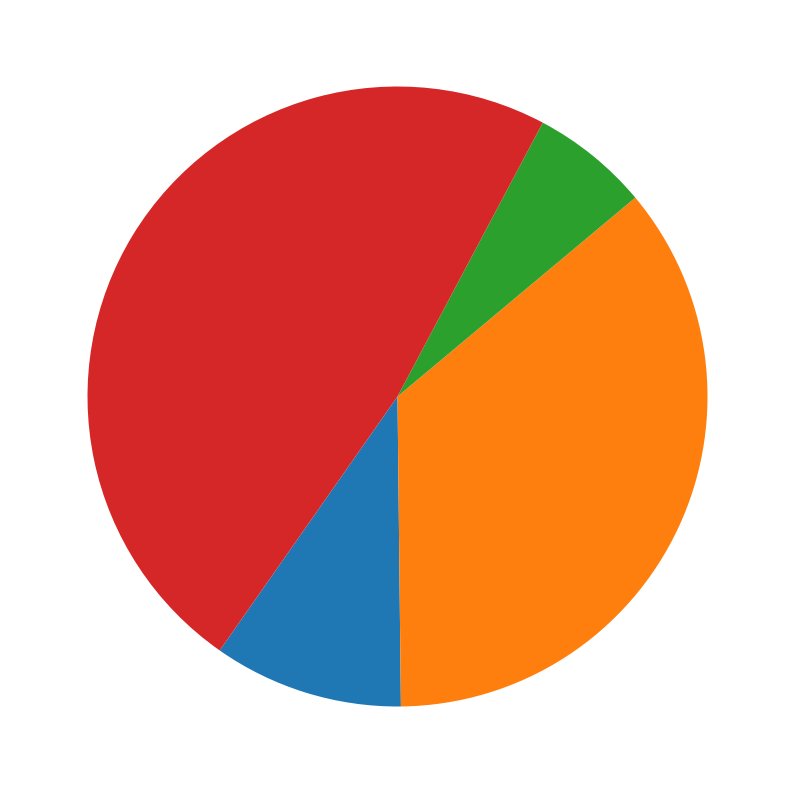

In [56]:
#Here, we show the proportion of the chemical classes in the entire CTD 
fig, ax = plt.subplots(figsize=(10, 20), subplot_kw=dict(aspect="equal"))
radius = 1

cmap = plt.cm.viridis


sizes=[len(chem_gene_hq_hub_exposures),len(chem_gene_hq_exp_significant_modules_central),len(chem_gene_hq_exp_significant_modules_peripheric),len(chem_gene_hq_exp_no_central_no_module)]

wedges, texts = ax.pie(sizes, wedgeprops=dict(width=1), startangle=-125)

bbox_props = dict(boxstyle="square,pad=0.2", fc="w", ec="k", lw=1.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

#for i, p in enumerate(wedges):
#    ang = (p.theta2 - p.theta1)/2. + p.theta1
#    y = np.sin(np.deg2rad(ang))
#    x = np.cos(np.deg2rad(ang))
#    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
#    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
#    kw["arrowprops"].update({"connectionstyle": connectionstyle})
#    ax.annotate(labels[i], xy=(x, y), xytext=(1.8*np.sign(x), 2.5*y),
#                horizontalalignment=horizontalalignment,fontsize=24, **kw)
plt.savefig('output/Figures/SF7A_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")

plt.show()

In [59]:
output_file = open('output/HomoHQ_No_central_no_module_exposures.txt', 'w')

for exp in chem_gene_hq_exp_no_central_no_module:
    output_file.write(exp + '\n')

output_file.close()

In [60]:
output_file = open('output/HomoHQ_Hub_exposures.txt', 'w')

for exp in list(chem_gene_hq_hub_exposures.keys()):
    output_file.write(exp + '\n')

output_file.close()

In [61]:
output_file = open('output/HomoHQ_Central_module_exposures.txt', 'w')

for exp in list(chem_gene_hq_exp_significant_modules_central.keys()):
    output_file.write(exp + '\n')

output_file.close()

In [62]:
output_file = open('output/HomoHQ_Peripheric_module_exposures.txt', 'w')

for exp in list(chem_gene_hq_exp_significant_modules_peripheric.keys()):
    output_file.write(exp + '\n')

output_file.close()

In [66]:


#chem_gene_homo_mouse
chem_gene_homo_mouse_ppi={}
for k,v in chem_gene_homo_mouse.items():
    new_list=[]
    for gene in v:
        if gene in G_ppi_lcc.nodes():
            new_list.append(gene)
        else:
            pass
    if len(new_list)>0:
        chem_gene_homo_mouse_ppi[k]=new_list
    else:
        pass

In [ ]:
import math
chem_gene_homo_mouse_ppi_zscore={}

for exp in chem_gene_homo_mouse_ppi.keys():
    if len(chem_gene_homo_mouse_ppi[exp])>1: #let's exclude those exposures that perturb only one gene
        geneset = set(chem_gene_homo_mouse_ppi[exp])
        G_sub = nx.subgraph(G_ppi_lcc,geneset)
        G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph
        f_lcc_size = G_sub_lcc.number_of_nodes()
        l_random_lccs = []
        S = 1000
        for s in range(S):
            gene_sample = rd.sample(list(G_ppi_lcc.nodes()),len(geneset))
            G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)
            G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
            lcc_size = G_sub_rnd_lcc.number_of_nodes()
            l_random_lccs.append(lcc_size)
        mu = np.mean(l_random_lccs)
        std = np.std(l_random_lccs)
        z = round(((f_lcc_size-mu)/std),3)
        chem_gene_homo_mouse_ppi_zscore[exp]=z


add_chem_gene_homo_mouse_ppi_zscore={}
for exp,z in chem_gene_homo_mouse_ppi_zscore.items():
    if str(z)=="nan" or str(z)=="inf":
        if len(chem_gene_homo_mouse_ppi[exp])>1:
            geneset = set(chem_gene_homo_mouse_ppi[exp])
            G_sub = nx.subgraph(G_ppi_lcc,geneset)
            G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph
            f_lcc_size = G_sub_lcc.number_of_nodes()
            l_random_lccs = []
            S = 1000
            for s in range(S):
                gene_sample = rd.sample(list(G_ppi_lcc.nodes()),len(geneset))
                G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)
                G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
                lcc_size = G_sub_rnd_lcc.number_of_nodes()
                l_random_lccs.append(lcc_size)
            mu = np.mean(l_random_lccs)
            std = np.std(l_random_lccs)
            z = round(((f_lcc_size-mu)/std),3)
            add_chem_gene_homo_mouse_ppi_zscore[exp]=z


add_add_chem_gene_homo_mouse_ppi_zscore = {}
for exp,z in add_chem_gene_homo_mouse_ppi_zscore.items():
    if str(z)=="nan" or str(z)=="inf":
        if len(chem_gene_homo_mouse_ppi[exp])>1:
            geneset = set(chem_gene_homo_mouse_ppi[exp])
            G_sub = nx.subgraph(G_ppi_lcc,geneset)
            G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph
            f_lcc_size = G_sub_lcc.number_of_nodes()
            l_random_lccs = []
            S = 1000
            for s in range(S):
                gene_sample = rd.sample(list(G_ppi_lcc.nodes()),len(geneset))
                G_sub_rnd = nx.subgraph(G_ppi_lcc,gene_sample)
                G_sub_rnd_lcc = G_sub_rnd.subgraph(max(nx.connected_components(G_sub_rnd), key=len))  # extract lcc graph
                lcc_size = G_sub_rnd_lcc.number_of_nodes()
                l_random_lccs.append(lcc_size)
            mu = np.mean(l_random_lccs)
            std = np.std(l_random_lccs)
            z = round(((f_lcc_size-mu)/std),3)
            add_add_chem_gene_homo_mouse_ppi_zscore[exp]=z


final_chem_gene_homo_mouse_ppi_zscore={}
for exp,z in chem_gene_homo_mouse_ppi_zscore.items():
    if len(chem_gene_homo_mouse_ppi[exp])>1:   #I remove those exposures that perturb just one gene
        if str(z)!="nan" and str(z)!="inf":
            final_chem_gene_homo_mouse_ppi_zscore[exp]=z
        else:
            if str(add_chem_gene_homo_mouse_ppi_zscore[exp])!="nan" and str(add_chem_gene_homo_mouse_ppi_zscore[exp])!="inf":
                final_chem_gene_homo_mouse_ppi_zscore[exp]=add_chem_gene_homo_mouse_ppi_zscore[exp]
            else:
                final_chem_gene_homo_mouse_ppi_zscore[exp]=add_add_chem_gene_homo_mouse_ppi_zscore[exp]

In [ ]:
with open('intermediate/final_chem_gene_homo_mouse_ppi_zscore.pickle', 'wb') as handle:
    pk.dump(final_chem_gene_homo_mouse_ppi_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)

In [63]:
with open('intermediate/final_chem_gene_homo_mouse_ppi_zscore.pickle', 'rb') as handle:
    final_chem_gene_homo_mouse_ppi_zscore = pk.load(handle)

In [67]:
chem_gene_homo_mouse_ppi_hub_exposures={}
chem_gene_homo_mouse_ppi_exp_significant_modules={}
for k,v in final_chem_gene_homo_mouse_ppi_zscore.items():
    if float(v)>2:
        chem_gene_homo_mouse_ppi_exp_significant_modules[k]=v
    else:
        geneset=chem_gene_homo_mouse_ppi[k]
        geneset_degree=[]
        for gene in geneset:
            geneset_degree.append(G_ppi_lcc.degree[gene])
            if any(y > degree_90percentile for y in geneset_degree):
                    chem_gene_homo_mouse_ppi_hub_exposures[k]=v
            else:
                pass

chem_gene_homo_mouse_ppi_exp_significant_modules_central={}
chem_gene_homo_mouse_ppi_exp_significant_modules_peripheric={}
for k,v in chem_gene_homo_mouse_ppi_exp_significant_modules.items():
    geneset=chem_gene_homo_mouse_ppi[k]
    geneset_degree=[]
    for gene in geneset:
        geneset_degree.append(G_ppi_lcc.degree[gene])
    if any(y > degree_90percentile for y in geneset_degree):
        chem_gene_homo_mouse_ppi_exp_significant_modules_central[k]=v
    else:
        chem_gene_homo_mouse_ppi_exp_significant_modules_peripheric[k]=v

In [68]:
chem_gene_homo_mouse_no_central_no_module = []

for chem in chem_gene_homo_mouse_ppi.keys():
    if chem not in chem_gene_homo_mouse_ppi_exp_significant_modules.keys() and chem not in chem_gene_homo_mouse_ppi_hub_exposures.keys():
        chem_gene_homo_mouse_no_central_no_module.append(chem)


print(len(chem_gene_homo_mouse_no_central_no_module))
print(len(chem_gene_homo_mouse_ppi_hub_exposures))
print(len(chem_gene_homo_mouse_ppi_exp_significant_modules_central))
print(len(chem_gene_homo_mouse_ppi_exp_significant_modules_peripheric))

print(len(chem_gene_homo_mouse_no_central_no_module)+len(chem_gene_homo_mouse_ppi_hub_exposures)+len(chem_gene_homo_mouse_ppi_exp_significant_modules_central)+len(chem_gene_homo_mouse_ppi_exp_significant_modules_peripheric)==len(chem_gene_homo_mouse_ppi))


4254
1159
5091
833
True


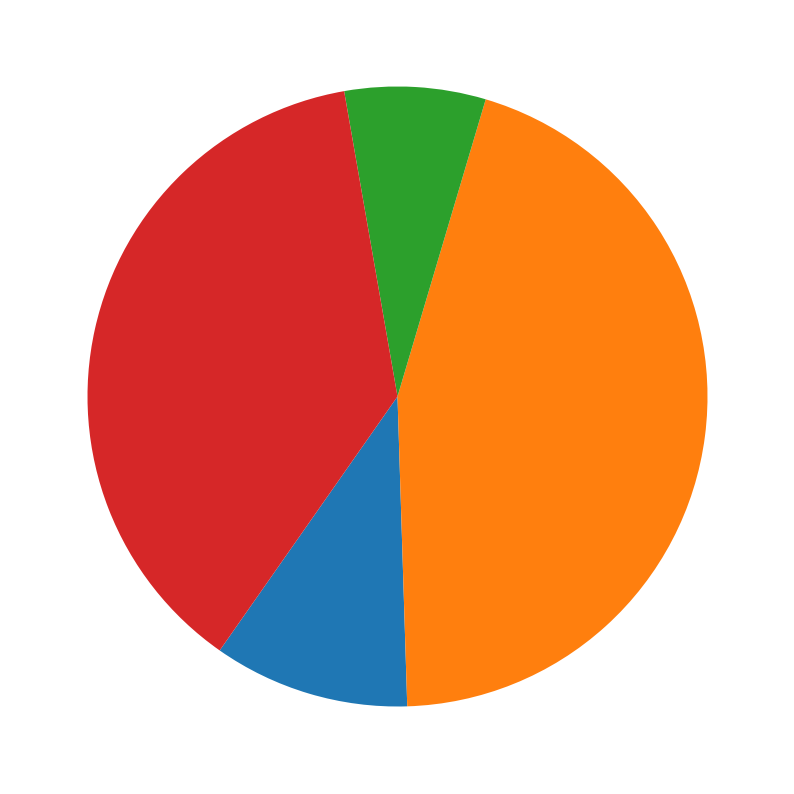

In [69]:
#Here, we show the proportion of the chemical classes in the entire CTD 
fig, ax = plt.subplots(figsize=(10, 20), subplot_kw=dict(aspect="equal"))
radius = 1

cmap = plt.cm.viridis


sizes=[len(chem_gene_homo_mouse_ppi_hub_exposures),len(chem_gene_homo_mouse_ppi_exp_significant_modules_central),len(chem_gene_homo_mouse_ppi_exp_significant_modules_peripheric),len(chem_gene_homo_mouse_no_central_no_module)]

wedges, texts = ax.pie(sizes, wedgeprops=dict(width=1), startangle=-125)

bbox_props = dict(boxstyle="square,pad=0.2", fc="w", ec="k", lw=1.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

#for i, p in enumerate(wedges):
#    ang = (p.theta2 - p.theta1)/2. + p.theta1
#    y = np.sin(np.deg2rad(ang))
#    x = np.cos(np.deg2rad(ang))
#    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
#    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
#    kw["arrowprops"].update({"connectionstyle": connectionstyle})
#    ax.annotate(labels[i], xy=(x, y), xytext=(1.8*np.sign(x), 2.5*y),
#                horizontalalignment=horizontalalignment,fontsize=24, **kw)
plt.savefig('output/Figures/SF7B_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")

plt.show()

In [70]:
lcc_zscore_2_df=pd.DataFrame()

category_list=[]
zscore_list=[]
for z in [v for v in final_exposome_zscore.values() if str(v)!='nan' and str(v)!='inf']:
    zscore_list.append(z)
    category_list.append("all exposures")
 
for z in [v for v in final_chem_gene_homo_mouse_ppi_zscore.values() if str(v)!='nan' and str(v)!='inf']:
    zscore_list.append(z)
    category_list.append("Homo-Mouse")

for z in [v for v in final_chem_gene_hq_ppi_zscore.values() if str(v)!='nan' and str(v)!='inf']:
    zscore_list.append(z)
    category_list.append("Homo HQ")   

lcc_zscore_2_df['group']=category_list
lcc_zscore_2_df['z-score']=zscore_list

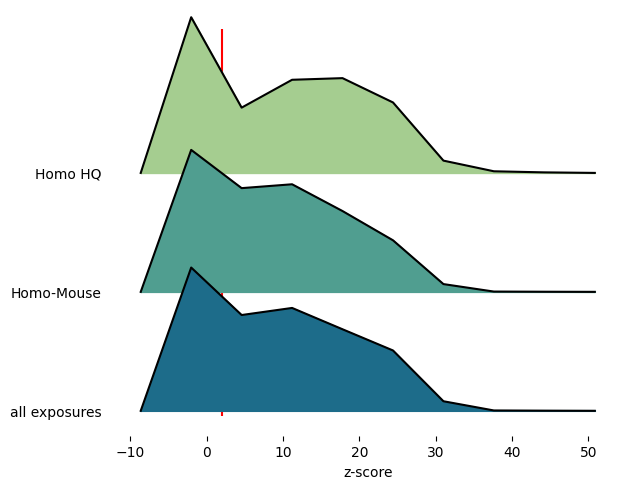

In [71]:
from joypy import joyplot
import seaborn as sns

joyplot(lcc_zscore_2_df, by='group', kind = "normalized_counts",column='z-score',colormap=sns.color_palette("crest", as_cmap=True));

plt.xlabel('z-score');
plt.vlines(x=2,ymin=0,ymax=1,color='r',label='statistically significance',zorder=10);
plt.savefig('output/Figures/SF7C_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [72]:
output_file = open('output/HomoMouse_No_central_no_module_exposures.txt', 'w')

for exp in chem_gene_homo_mouse_no_central_no_module:
    output_file.write(exp + '\n')

output_file.close()

In [73]:
output_file = open('output/HomoMouse_Hub_exposures.txt', 'w')

for exp in list(chem_gene_homo_mouse_ppi_hub_exposures.keys()):
    output_file.write(exp + '\n')

output_file.close()

In [74]:
output_file = open('output/HomoMouse_Central_module_exposures.txt', 'w')

for exp in list(chem_gene_homo_mouse_ppi_exp_significant_modules_central.keys()):
    output_file.write(exp + '\n')

output_file.close()

In [75]:
output_file = open('output/HomoMouse_Peripheric_module_exposures.txt', 'w')

for exp in list(chem_gene_homo_mouse_ppi_exp_significant_modules_peripheric.keys()):
    output_file.write(exp + '\n')

output_file.close()